# Controlled Bouncing Ball

Example taken from: ProbReach paper

```
mass R = ?, C = ?, H = ?

repeat {
    if H<= 0 {
        mode = 1
    }
    else {
        mode = -1
    }
}
```

Height and velocity evolve according to:
$$ \frac{d \textit{H}}{dt} = \begin{cases} v & \text{if mode = -1} \\
                                             v & \text{if mode = 1}  \end{cases} $$

$$ \frac{d \textit{v}}{dt} = \begin{cases} -g & \text{if mode = -1} \\
                                              - g - \frac{Rv + \frac{H}{C}}{m} & \text{if mode = 1}  \end{cases} $$


We try to synthesize R and H/C in order to maximize the probability that the ball reaches H >=7 in mode 1 after making one bounce

## SOGA

In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
print(sys.path)

from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from libSOGA import *
from time import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd

['/Users/rominadoz/micromamba/envs/simple_env/lib/python312.zip', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/lib-dynload', '', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/site-packages', '/Users/rominadoz/Desktop/Home/PhD/SOGA/DeGAS/src']


In [2]:
from optimization import *
torch.set_default_dtype(torch.float64)

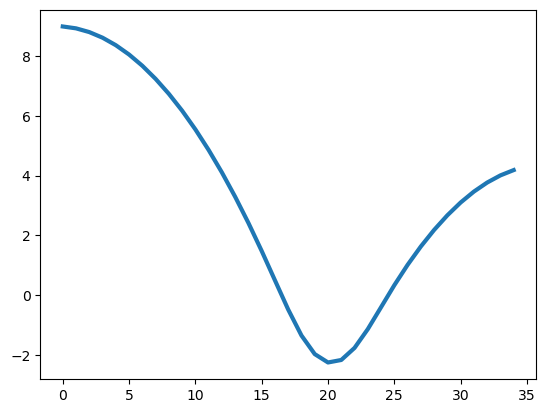

In [3]:
soga_code = """
array[36] H;

/* Initial state */
currH = gauss(9., 1.);   
mode = -1.;
currV = 0.;

bounced = -1.;
valid = -1.;
count = 0.;

dt = 0.08;            

for i in range(35) {
    /* Save current state */
    H[i] = currH;

    /* Continuous dynamics */

    if mode < 0 {
        /* falling down */
        temp = -9.8 * dt;
        newV = currV + temp + gauss(0., 0.1);
    } else {
        /* going up */
        temp = -9.8 * dt;

        spring = _R*currV;
        temp2 = _C*currH;
        spring = spring + temp2;
        spring = spring * dt; 
        spring = 0.14 * spring; 
        newV = currV + temp - spring + gauss(0., 0.1);

    } end if;
    currV = newV;

    temp = currV * dt;
    newH = currH + temp + gauss(0., 0.1);

    currH = newH;

    /* Mode switching */
    if mode < 0 {
        if currH <= 0. {
            mode = 1;
            bounced = 1.;
        } else {
            skip;
        } end if;
    } else {
        if currH > 0. {
            mode = -1;
            if bounced > 0. {
                valid = count;
            } else {
                skip;
            } end if;
        } else {
            skip;
        } end if;
    } end if;
    count = count + 1.;
} end for;

/* Save final state */
H[35] = currH;

"""

compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)

# initialize parameters
params = {'R':  7., 'C':200.}
params_dict = initialize_params(params)  

# computes SOGA output
output_dist = start_SOGA(cfg, params_dict)

#plot
y_init = output_dist.gm.mean()[:35].detach()
plt.plot(range(35), y_init, lw=3, label='SOGA w true params')

# Points to which the lines should be drawn
#points = [(6, 20), (18, 20), (24, 20)]

# Plot the points on the graph
#for point in points:
    #plt.plot(point[0], point[1], 'ro')  # Red dot at each point
#plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')

In [4]:
y = []
y_var = []
for i in range(35):
    y.append(output_dist.gm.mean()[output_dist.var_list.index('H['+ str(i) +']')].detach().numpy())
    y_var.append(torch.sqrt(output_dist.gm.cov()[output_dist.var_list.index('H['+ str(i) +']'), output_dist.var_list.index('H['+ str(i) +']')]).detach().numpy())

df = pd.DataFrame({'Y_mean': y, 'Y_std': y_var})
df.to_csv('bouncing_ball2_init.csv', index=False)

In [5]:
# find the index of the elemnet of the list output_dist.var_list corresponding to 'valid'
valid_var = [i for i, var in enumerate(output_dist.var_list) if var == 'valid']
print(int(output_dist.gm.mean()[valid_var[0]]))
print(torch.argmax(output_dist.gm.mean()[int(output_dist.gm.mean()[valid_var[0]]):35])+ int(output_dist.gm.mean()[valid_var[0]]) )

23
tensor(34)


In [6]:
# The loss maximize the probability of being > 7, having done a bounce and being in mode -1
#loss = lambda dist : - (1 - dist.gm.marg_cdf(torch.tensor([7.]), idx=int(output_dist.gm.mean()[valid_var[0]])))
#loss = lambda dist : -torch.max(torch.tensor([(1 - dist.gm.marg_cdf(torch.tensor([7.]), idx=i)) * (1 - dist.gm.marg_cdf(torch.tensor([i]), idx=valid_var[0])) for i in range(35)]) )
#loss = lambda dist : torch.argmax(dist.gm.mean()[:35])
loss = lambda dist : - (1 - dist.gm.marg_cdf(torch.tensor([7.]), idx=torch.argmax(dist.gm.mean()[int(output_dist.gm.mean()[valid_var[0]]):35]) + int(output_dist.gm.mean()[valid_var[0]])))
loss(output_dist)


tensor([[-0.0019]], grad_fn=<NegBackward0>)

R: 6.800000842537942 C: 200.19998187536237  loss: -0.0019262359044346367
R: 6.600168329272724 C: 200.3998136033988  loss: -0.0024875738168534944
R: 6.400536496517866 C: 200.59946699150987  loss: -0.0031978194230901646
R: 6.201070916984978 C: 200.79898573255971  loss: -0.0040919501820869675
R: 6.001671699108353 C: 200.99848518058698  loss: -0.0052123494352860344
R: 5.8021830344279115 C: 201.198143281379  loss: -0.006610337154619339
R: 5.6024059774815615 C: 201.39818645067905  loss: -0.008347959752916467
R: 5.402111667962696 C: 201.5988739901481  loss: -0.010500028777466364
R: 5.201053165316338 C: 201.8004835837303  loss: -0.013156379856536615
R: 4.998975013489144 C: 202.0032992480444  loss: -0.016424291117464906
R: 4.795620363245596 C: 202.2076021361155  loss: -0.020430964077799874
R: 4.590735907797549 C: 202.41366398639292  loss: -0.025325914923258863
R: 4.384075086998807 C: 202.62174270572942  loss: -0.031283057681992354
R: 4.175400064219834 C: 202.8320794789993  loss: -0.038502181387

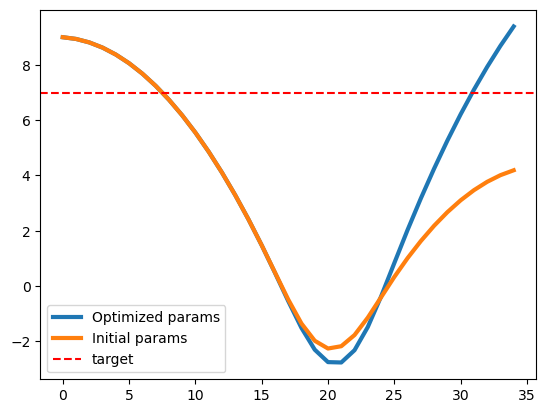

In [7]:
params_dict = initialize_params(params)
T = 35
# gradient based optimization
loss_list = optimize(cfg, params_dict, loss, n_steps=50, lr=0.2)

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")

compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict)
y_opt = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_opt, lw=3, label='Optimized params')
plt.plot(range(35), y_init, lw=3, label='Initial params')
#add horizontal line at y=20
plt.axhline(y=7, color='r', linestyle='--', label='target')
plt.legend()

In [8]:
y = []
y_var = []
for i in range(35):
    y.append(output_dist.gm.mean()[output_dist.var_list.index('H['+ str(i) +']')].detach().numpy())
    y_var.append(torch.sqrt(output_dist.gm.cov()[output_dist.var_list.index('H['+ str(i) +']'), output_dist.var_list.index('H['+ str(i) +']')]).detach().numpy())

df = pd.DataFrame({'Y_mean': y, 'Y_std': y_var})
df.to_csv('bouncing_ball2_opt.csv', index=False)

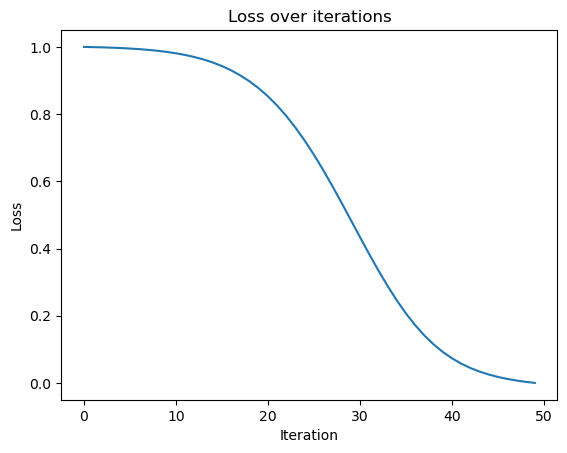

In [10]:
# export loss_list to csv
#normalize loss_list
loss_list = (np.array(loss_list) - np.min(loss_list)) / (np.max(loss_list) - np.min(loss_list))
df_loss = pd.DataFrame({'Loss': loss_list})
df_loss.to_csv('bouncing_ball2_loss.csv', index=False)

#plot

plt.plot(df_loss['Loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over iterations')
plt.show()